In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from tensorflow.examples.tutorials.mnist import input_data
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Compute the time elapsed
"""
def tic():
    global tic_time
    tic_time = time.time()
    
def toc():
    return time.time() - tic_time

In [3]:
"""
Load MNIST data
Return: all 70000(train + val + test) images
"""
def load_data():
    mnist = input_data.read_data_sets('MNIST_data/')
    images = np.append(np.append(mnist.train.images, mnist.validation.images, axis=0), mnist.test.images, axis=0)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        mnist_images_64 = sess.run(tf.image.resize_images(images.reshape(-1, 28, 28, 1), [64, 64]))
    return mnist_images_64 #shape = (70000, 64, 64, 1)

In [4]:
"""
Define the Generator
"""
def generator(noises_input, n_1, n_2, n_3, n_4, n_out, is_training):
    with tf.variable_scope('generator'):
        Z1 = tf.contrib.layers.conv2d_transpose(noises_input, n_1, (4, 4), stride=1, padding='VALID', activation_fn=None, scope='Z1')
        A1 = tf.nn.leaky_relu(Z1, name='A1')
        Z2 = tf.contrib.layers.conv2d_transpose(A1, n_2, (4, 4), stride=2, padding='SAME', activation_fn=None, scope='Z2')
        Z2_bn = tf.layers.batch_normalization(Z2, axis=3, training=is_training, name='Z2_bn')
        A2 = tf.nn.leaky_relu(Z2_bn, name='A2')
        Z3 = tf.contrib.layers.conv2d_transpose(A2, n_3, (4, 4), stride=2, padding='SAME', activation_fn=None, scope='Z3')
        Z3_bn = tf.layers.batch_normalization(Z3, axis=3, training=is_training, name='Z3_bn')
        A3 = tf.nn.leaky_relu(Z3_bn, name='A3')
        Z4 = tf.contrib.layers.conv2d_transpose(A3, n_4, (4, 4), stride=2, padding='SAME', activation_fn=None, scope='Z4')
        Z4_bn = tf.layers.batch_normalization(Z4, axis=3, training=is_training, name='Z4_bn')
        A4 = tf.nn.leaky_relu(Z4_bn, name='A4')
        Z_out = tf.contrib.layers.conv2d_transpose(A4, n_out, (4, 4), stride=2, padding='SAME', activation_fn=None, scope='Z_out')
        A_out = tf.nn.tanh(Z_out, name='A_out')
    return A_out

In [5]:
"""
Define the Discriminator
"""
def discriminator(images_input, n_1, n_2, n_3, n_4, n_out, is_training, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        Z1 = tf.contrib.layers.conv2d(images_input, n_1, (4, 4), stride=2, padding='SAME', activation_fn=None, scope='Z1')
        A1 = tf.nn.leaky_relu(Z1, name='A1')
        Z2 = tf.contrib.layers.conv2d(A1, n_2, (4, 4), stride=2, padding='SAME', activation_fn=None, scope='Z2')
        Z2_bn = tf.layers.batch_normalization(Z2, axis=3, training=is_training, name='Z2_bn')
        A2 = tf.nn.leaky_relu(Z2_bn, name='A2')
        Z3 = tf.contrib.layers.conv2d(A2, n_3, (4, 4), stride=2, padding='SAME', activation_fn=None, scope='Z3')
        Z3_bn = tf.layers.batch_normalization(Z3, axis=3, training=is_training, name='Z3_bn')
        A3 = tf.nn.leaky_relu(Z3_bn, name='A3')
        Z4 = tf.contrib.layers.conv2d(A3, n_4, (4, 4), stride=2, padding='SAME', activation_fn=None, scope='Z4')
        Z4_bn = tf.layers.batch_normalization(Z4, axis=3, training=is_training, name='Z4_bn')
        A4 = tf.nn.leaky_relu(Z4_bn, name='A4')
        Z_out = tf.contrib.layers.conv2d(A4, n_out, (4, 4), stride=1, padding='VALID', activation_fn=None, scope='Z5')
    return Z_out

In [6]:
"""
Define and Train Deep Convolutional Generative Adversarial Networks(DCGANs) Model
Return: history of costs(both generator and discriminator) 
        samples generated in each epoch
"""
def MNIST_DCGAN(hyperparams):
    tf.reset_default_graph()
    
    #Load data#
    mnist_images = load_data() * 2 - 1 #shape = (70000, 64, 64, 1)
    
    #Hyperparameters settings and properties#
    noise_size = hyperparams['noise_size']
    batch_size = hyperparams['batch_size']
    label_smooth = hyperparams['label_smooth']
    epoch = hyperparams['epoch']
    generator_n_1 = hyperparams['generator_n_1']
    generator_n_2 = hyperparams['generator_n_2']
    generator_n_3 = hyperparams['generator_n_3']
    generator_n_4 = hyperparams['generator_n_4']
    generator_n_out = hyperparams['generator_n_out']
    discriminator_n_1 = hyperparams['discriminator_n_1']
    discriminator_n_2 = hyperparams['discriminator_n_2']
    discriminator_n_3 = hyperparams['discriminator_n_3']
    discriminator_n_4 = hyperparams['discriminator_n_4']
    discriminator_n_out = hyperparams['discriminator_n_out']
    gen_learning_rate = hyperparams['gen_learning_rate']
    dis_learning_rate = hyperparams['dis_learning_rate']
    adam_beta1 = hyperparams['adam_beta1']
    sample_size = hyperparams['sample_size']
    data_size = mnist_images.shape[0]
    image_H = mnist_images.shape[1]
    image_W = mnist_images.shape[2]
    image_C = mnist_images.shape[3]
    total_batches = np.ceil(data_size / batch_size).astype(np.int32)
    
    #Define placeholders#
    real_images = tf.placeholder(tf.float32, (None, image_H, image_W, image_C), name='real_images')
    noises_input = tf.placeholder(tf.float32, (None, 1, 1, noise_size), name='noises_input')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    #Define the outputs of generator and discriminator#
    fake_images = generator(noises_input, generator_n_1, generator_n_2, generator_n_3, generator_n_4, generator_n_out, is_training)
    real_logits = discriminator(real_images, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_4, discriminator_n_out, is_training)
    fake_logits = discriminator(fake_images, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_4, discriminator_n_out, is_training, reuse=True)
    
    #Define costs of discriminator(fake and real data) and generator#
    dis_real_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.subtract(tf.ones_like(real_logits), label_smooth)))
    dis_fake_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    dis_cost = tf.divide(tf.add(dis_real_cost, dis_fake_cost), 2)
    gen_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    
    #Define the optimization#
    trainable_vars = tf.trainable_variables()
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    dis_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_optimize = tf.train.AdamOptimizer(learning_rate=gen_learning_rate, beta1=adam_beta1, name='gen_optimize').minimize(gen_cost, var_list=gen_vars)
        dis_optimize = tf.train.AdamOptimizer(learning_rate=dis_learning_rate, beta1=adam_beta1, name='dis_optimize').minimize(dis_cost, var_list=dis_vars)
    
    #Training#
    costs_history = []
    sample_images_generated = np.empty((0, sample_size, image_H, image_W, image_C))
    sample_noises_input = np.random.uniform(low=-1, high=1, size=(sample_size, 1, 1, noise_size))
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            tic()
            dis_cost_real_epoch = 0.
            dis_cost_fake_epoch = 0.
            dis_cost_epoch = 0.
            gen_cost_epoch = 0.
            for j in range(total_batches):
                index_front = j * batch_size
                index_end = (j + 1) * batch_size if (j + 1) * batch_size < data_size else data_size
                images_batch = mnist_images[index_front:index_end].reshape(-1, image_H, image_W, image_C)
                noises_batch = np.random.uniform(low=-1, high=1, size=(index_end - index_front, 1, 1, noise_size))
                _, dis_cost_real_iter, dis_cost_fake_iter, dis_cost_iter = sess.run([dis_optimize, dis_real_cost, dis_fake_cost, dis_cost], feed_dict={real_images:images_batch, noises_input:noises_batch, is_training:True})
                _, gen_cost_iter = sess.run([gen_optimize, gen_cost], feed_dict={real_images:images_batch, noises_input:noises_batch, is_training:True})
                dis_cost_real_epoch += dis_cost_real_iter / data_size
                dis_cost_fake_epoch += dis_cost_fake_iter / data_size
                dis_cost_epoch += dis_cost_iter / data_size
                gen_cost_epoch += gen_cost_iter / data_size
            costs_history.append((dis_cost_real_epoch, dis_cost_fake_epoch, dis_cost_epoch, gen_cost_epoch))
            sample_images_generated_epoch = sess.run(fake_images, feed_dict={noises_input:sample_noises_input, is_training:False}).reshape(1, sample_size, image_H, image_W, image_C)
            sample_images_generated = np.append(sample_images_generated, sample_images_generated_epoch, axis=0)
            print('Epoch {}/{} Time Elapsed: {:.2f}s'.format(i + 1, epoch, toc()))
            print('Discriminator Cost: {:.4f} (Real: {:.4f} + Fake: {:.4f}) Generator Cost: {:.4f}'.format(dis_cost_epoch, dis_cost_real_epoch, dis_cost_fake_epoch, gen_cost_epoch))
        return costs_history, sample_images_generated

In [7]:
"""
Show graphs of costs of discriminator and generator
"""
def show_graphs(costs_history):
    costs = np.array(costs_history).T
    plt.figure(figsize=(20, 10))
    plt.ylabel('Cost')
    plt.xlabel('Epoch')
    plt.title('Cost - Epoch')
    plt.plot(costs[0], label='Discriminator Real Cost')
    plt.plot(costs[1], label='Discriminator Fake Cost')
    plt.plot(costs[2], label='Discriminator Total Cost')
    plt.plot(costs[3], label='Generator Cost')
    plt.legend(loc='best')
    plt.show()

In [8]:
"""
Show and save samples
Variables: 
    sample_images_generated shape: (num of epochs, num of samples in each epoch, num of rows of image, num of column of image)
    save: True if want to save the figures(pngs and gifs)
    folder_name: create the folder if not exists, save figures to the specific folder
"""
def show_save_samples(sample_images_generated, save=False, folder_name='MNIST_DCGAN_samples', gif_frame_duration=0.25):
    #Scale images to the range of [0, 1]#
    sample_images_generated = (sample_images_generated + 1) / 2
    
    #Create folder if not exists#
    if save and not os.path.exists('./{}'.format(folder_name)):
        os.mkdir(folder_name)
    
    #Parameters#
    epochs = sample_images_generated.shape[0]
    num_sample_each_epoch = sample_images_generated.shape[1]
    image_H = sample_images_generated.shape[2]
    image_W = sample_images_generated.shape[3]
    
    #Output and save figures#
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        for i in range(epochs):
            plt.figure(figsize=(2 * num_sample_each_epoch, 5))
            for j in range(num_sample_each_epoch):
                plt.subplot(1, num_sample_each_epoch, j + 1)
                plt.axis('off')
                
                #Resize image from 64x64 to 28x28 and plot it#
                image_to_show = sess.run(tf.image.resize_images(sample_images_generated[i, j].reshape(1, image_H, image_W, 1), [28, 28]))
                plt.imshow(image_to_show.reshape(28, 28), cmap='gray')
            plt.text(-169, 40, 'Epoch {}'.format(i + 1), fontsize=25) #adjust the text location
            if save:
                plt.savefig('./{}/{}.png'.format(folder_name, i + 1))
            plt.show()
            
    #Make GIF#
    if save:
        gif_frames = []
        for i in range(epochs):
            gif_frames.append(imageio.imread('./{}/{}.png'.format(folder_name, i + 1)))
        imageio.mimsave('./{}/evolution.gif'.format(folder_name), gif_frames, duration=gif_frame_duration)

In [9]:
"""
Define the hyperparameters
"""
hyperparams={
    'noise_size': 100,
    'batch_size': 128,
    'label_smooth': 0.15,
    'epoch': 100,
    'generator_n_1': 1024,
    'generator_n_2': 512,
    'generator_n_3': 256,
    'generator_n_4': 128,
    'generator_n_out': 1,
    'discriminator_n_1': 128,
    'discriminator_n_2': 256,
    'discriminator_n_3': 512,
    'discriminator_n_4': 1024,
    'discriminator_n_out': 1,
    'gen_learning_rate': 0.0003,
    'dis_learning_rate': 0.00001,
    'adam_beta1': 0.5,
    'sample_size': 10
}
costs_history, sample_images_generated = MNIST_DCGAN(hyperparams)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/100 Time Elapsed: 172.28s
Discriminator Cost: 1.2604 (Real: 1.0654 + Fake: 1.4553) Generator Cost: 2.1277
Epoch 2/100 Time Elapsed: 171.43s
Discriminator Cost: 0.6049 (Real: 0.8228 + Fake: 0.3870) Generator Cost: 1.8090
Epoch 3/100 Time Elapsed: 171.57s
Discriminator Cost: 0.6726 (Real: 0.8181 + Fake: 0.5270) Generator Cost: 0.9623
Epoch 4/100 Time Elapsed: 171.70s
Discriminator Cost: 0.6788 (Real: 0.8164 + Fake: 0.5412) Generator Cost: 0.9349
Epoch 5/100 Time Elapsed: 172.11s
Discriminator Cost: 0.6726 (Real: 0.8096 + Fake: 0.5355) Generator Cost: 0.9543
Epoch 6/100 Time Elapsed: 171.79s
Discriminator Cost: 0.6689 (Real: 0.8053 + Fake: 0.5325) Generator Cost: 0.9699
Epoch 7/100 Time Elapsed: 171.75s
Discriminator Cost: 0.6691 (Real: 0.8056 + Fake: 0.5326) Generator Cost: 0.9769
Epoch 8/

Epoch 71/100 Time Elapsed: 171.89s
Discriminator Cost: 0.3415 (Real: 0.5335 + Fake: 0.1496) Generator Cost: 2.8662
Epoch 72/100 Time Elapsed: 171.80s
Discriminator Cost: 0.3328 (Real: 0.5231 + Fake: 0.1425) Generator Cost: 2.9141
Epoch 73/100 Time Elapsed: 171.91s
Discriminator Cost: 0.3536 (Real: 0.5505 + Fake: 0.1567) Generator Cost: 2.8401
Epoch 74/100 Time Elapsed: 171.96s
Discriminator Cost: 0.3413 (Real: 0.5387 + Fake: 0.1438) Generator Cost: 2.9265
Epoch 75/100 Time Elapsed: 171.87s
Discriminator Cost: 0.3199 (Real: 0.5183 + Fake: 0.1215) Generator Cost: 3.0954
Epoch 76/100 Time Elapsed: 171.94s
Discriminator Cost: 0.3306 (Real: 0.5310 + Fake: 0.1303) Generator Cost: 2.9733
Epoch 77/100 Time Elapsed: 171.92s
Discriminator Cost: 0.3218 (Real: 0.5257 + Fake: 0.1179) Generator Cost: 3.1454
Epoch 78/100 Time Elapsed: 172.05s
Discriminator Cost: 0.3237 (Real: 0.5217 + Fake: 0.1258) Generator Cost: 3.1296
Epoch 79/100 Time Elapsed: 172.03s
Discriminator Cost: 0.3041 (Real: 0.5103 + Fa

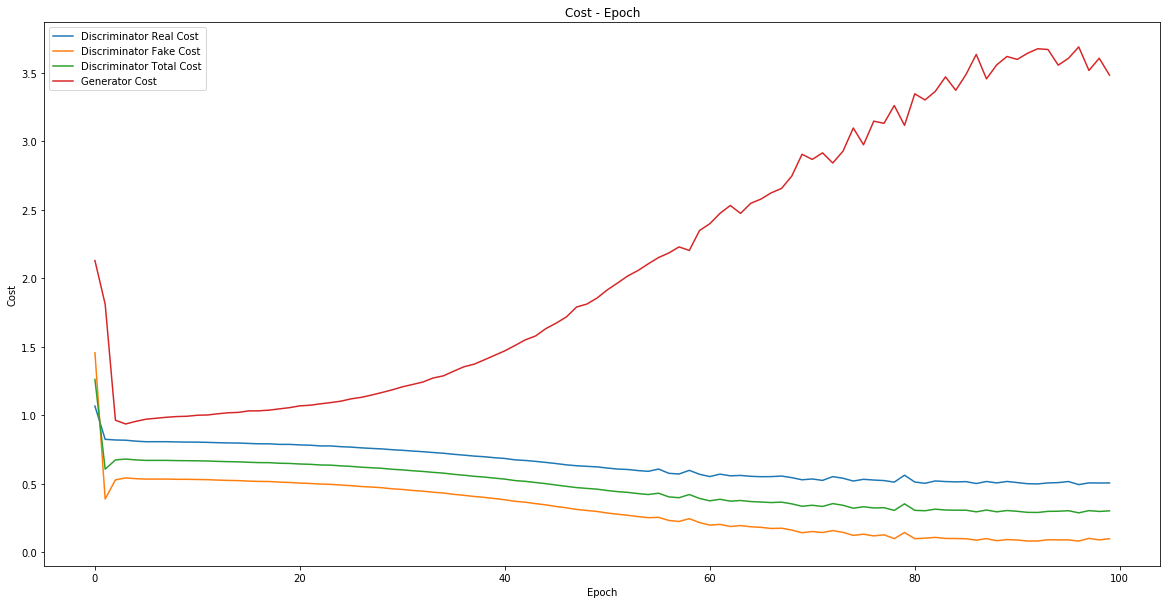

In [10]:
show_graphs(costs_history)

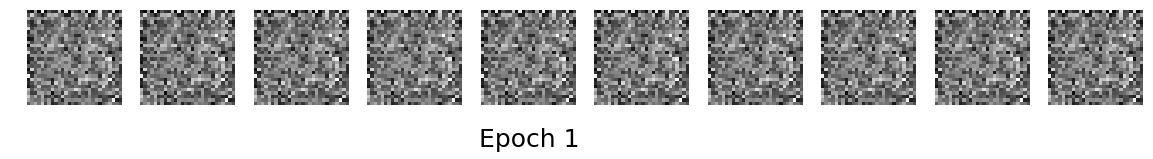

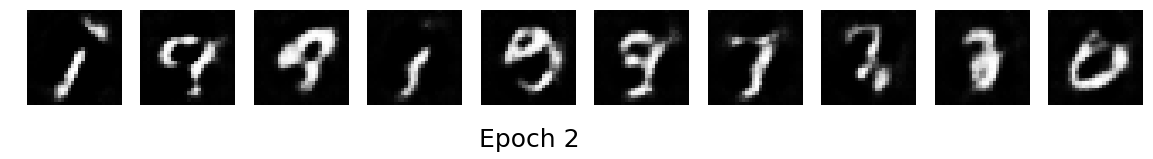

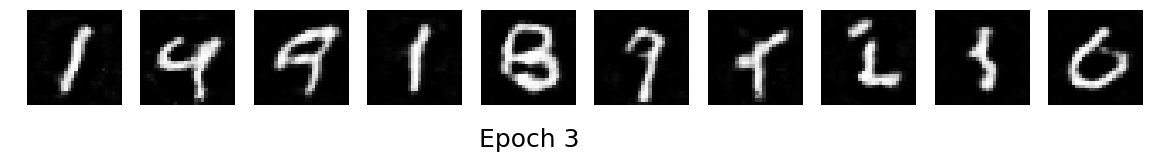

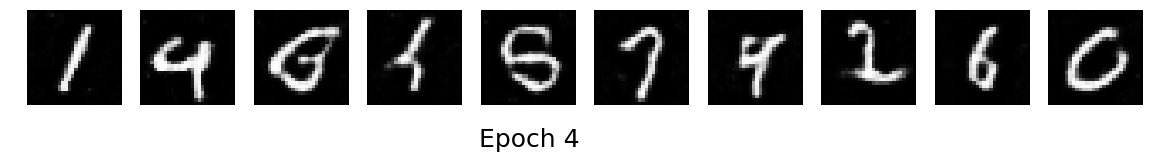

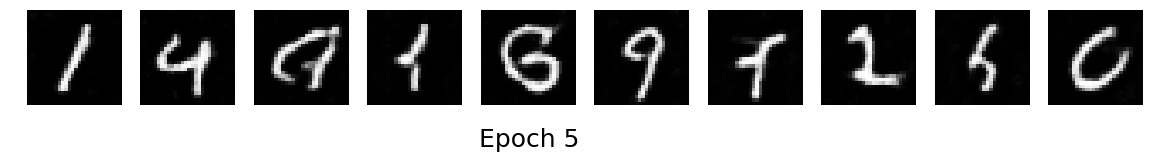

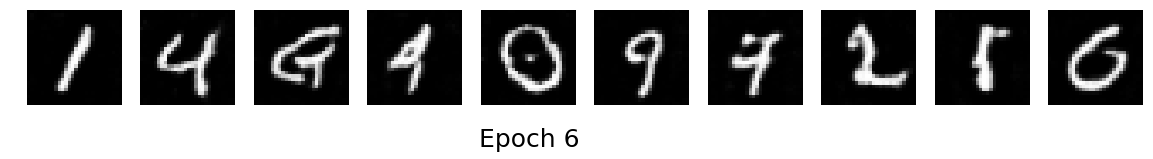

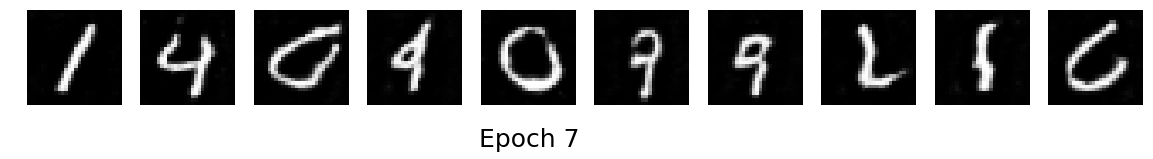

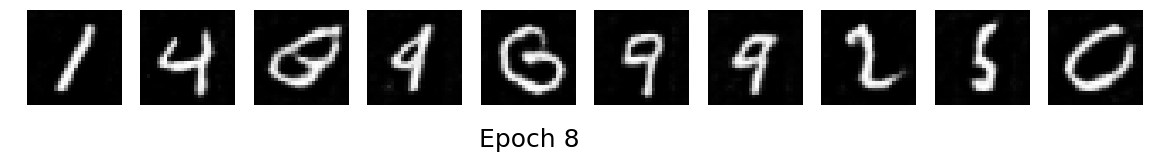

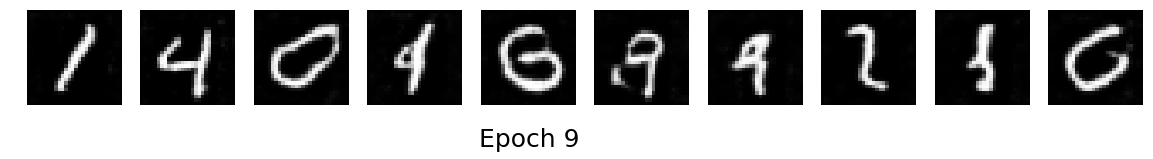

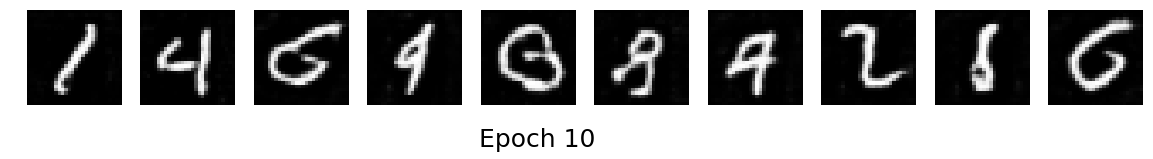

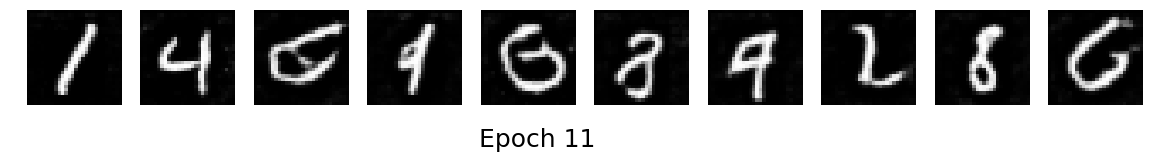

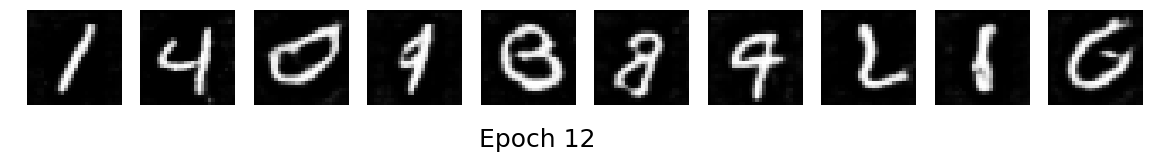

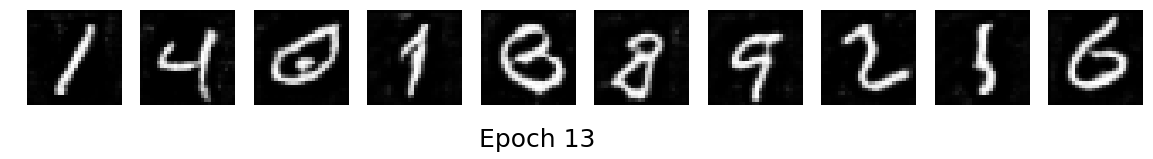

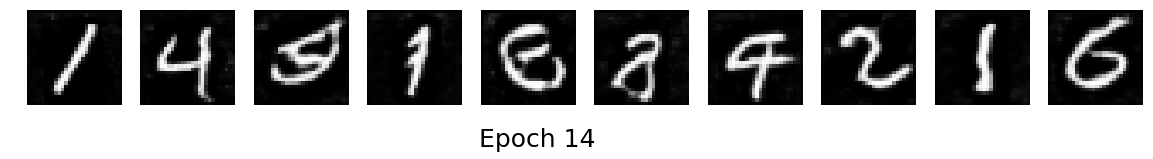

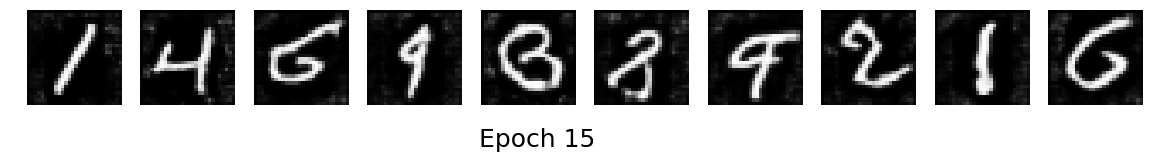

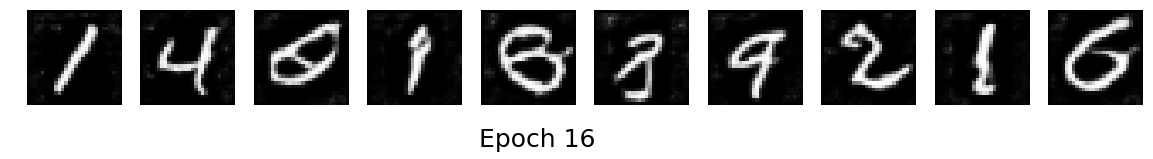

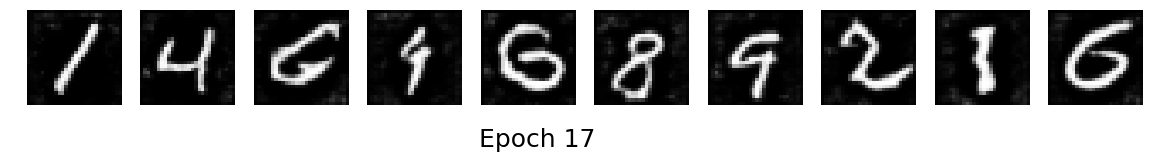

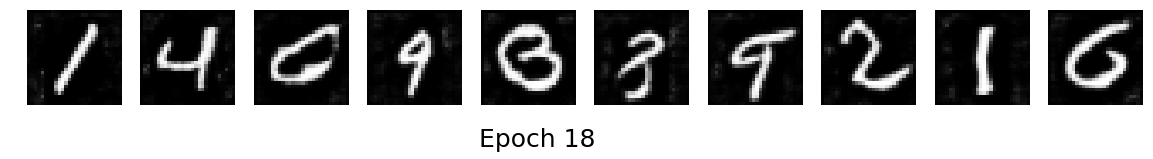

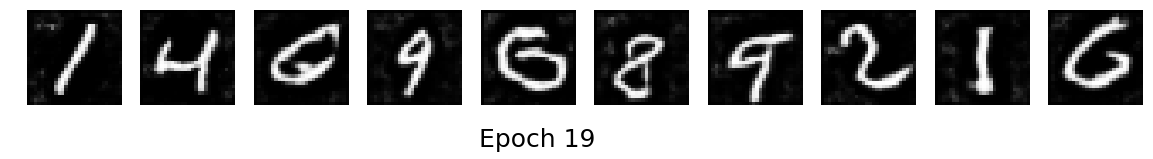

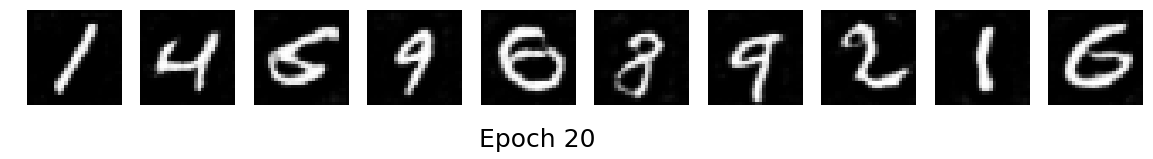

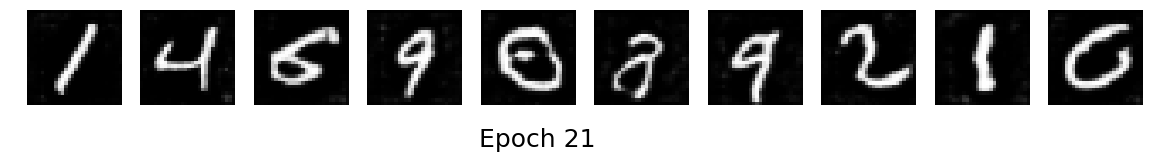

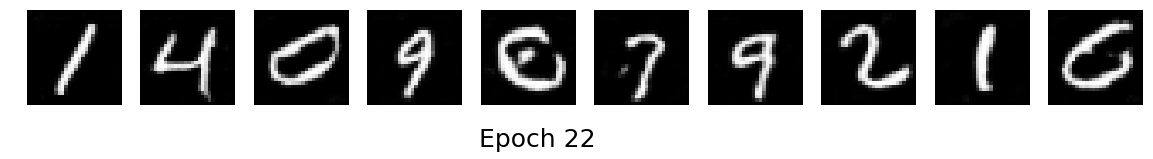

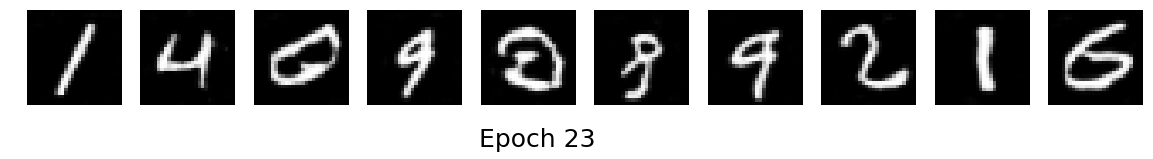

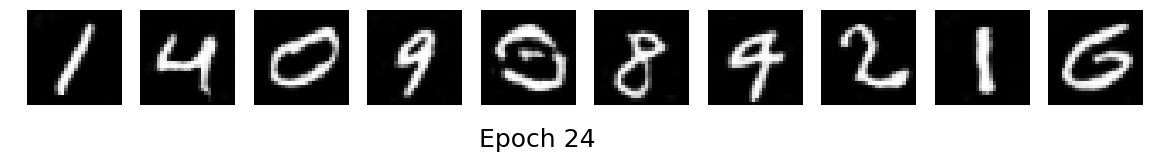

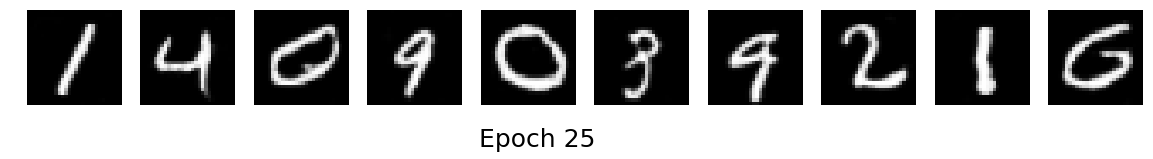

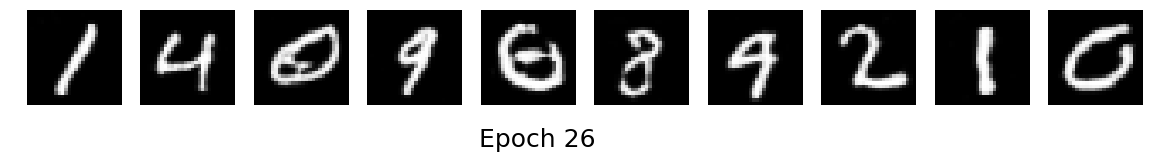

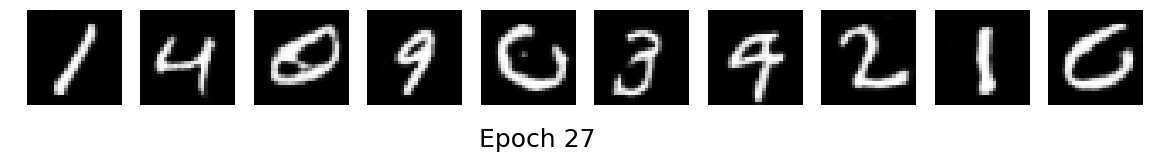

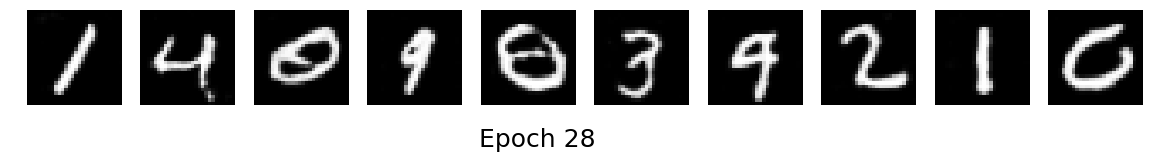

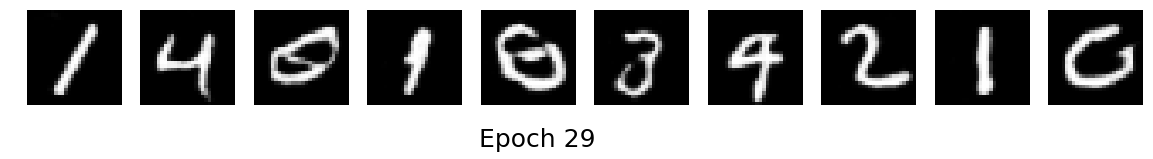

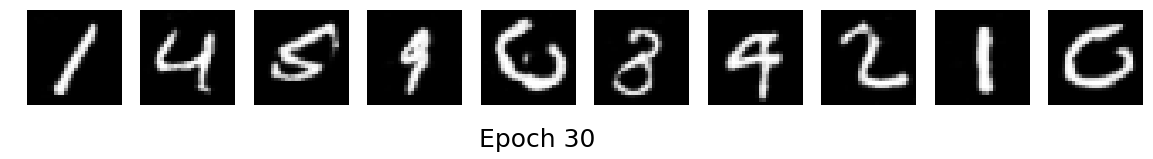

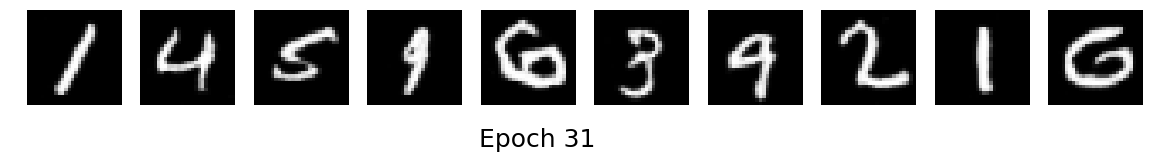

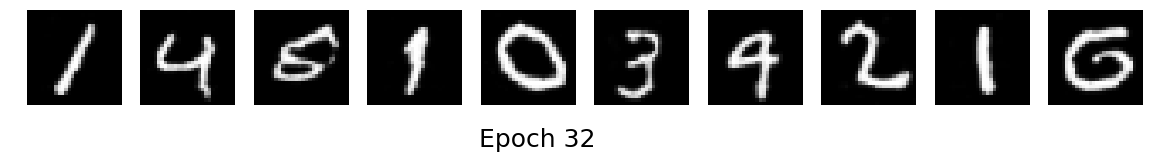

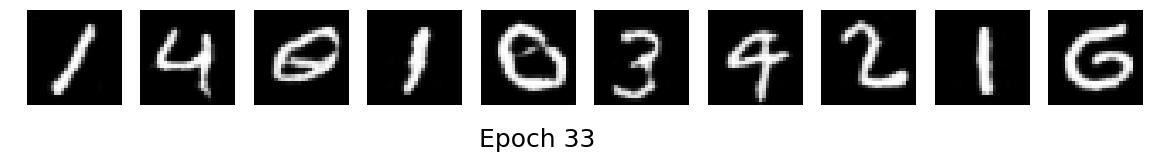

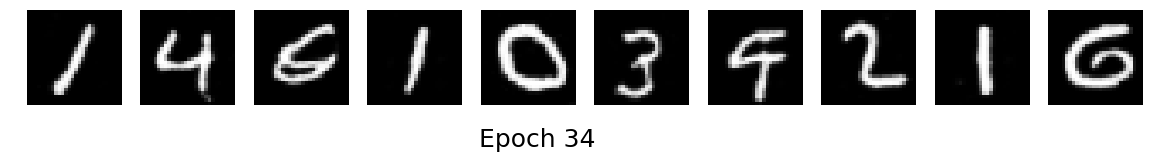

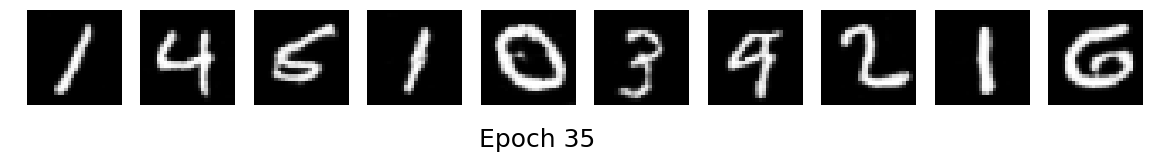

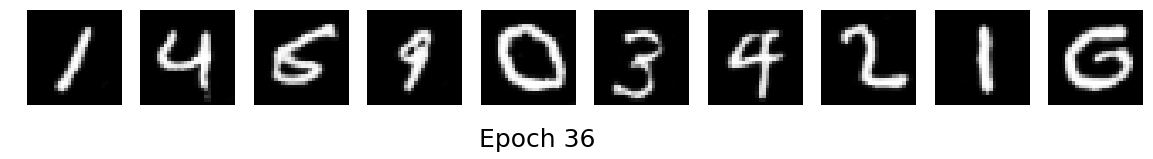

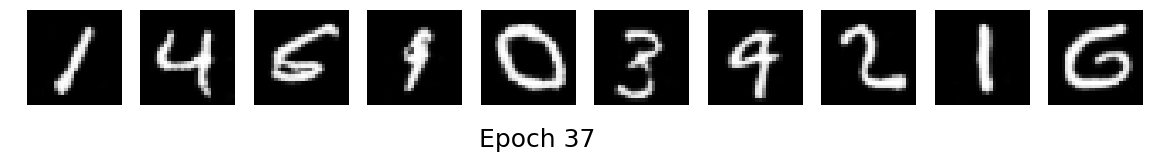

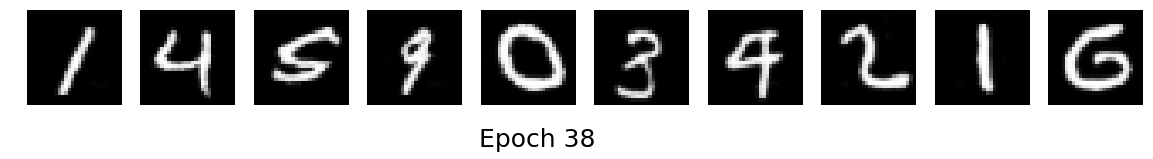

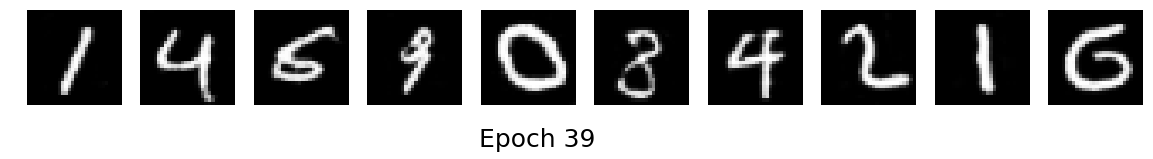

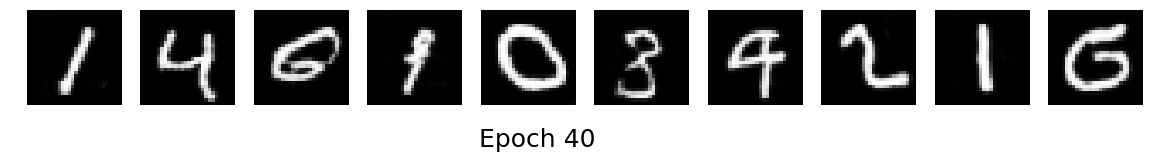

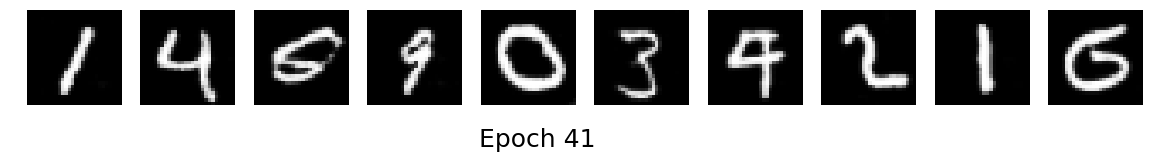

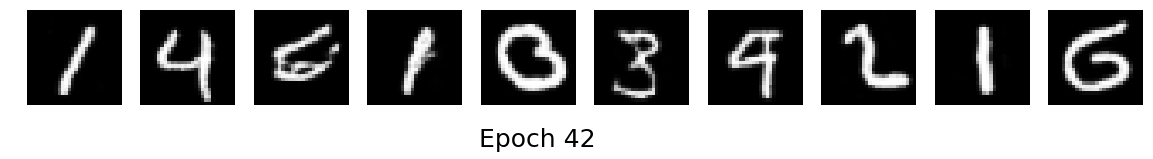

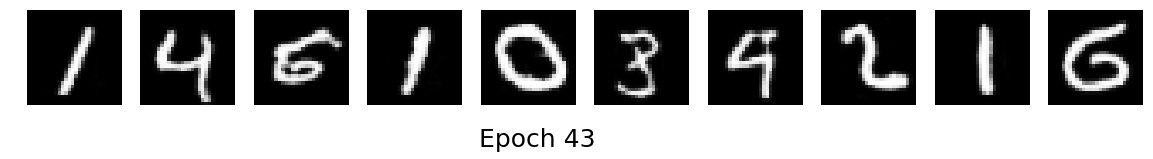

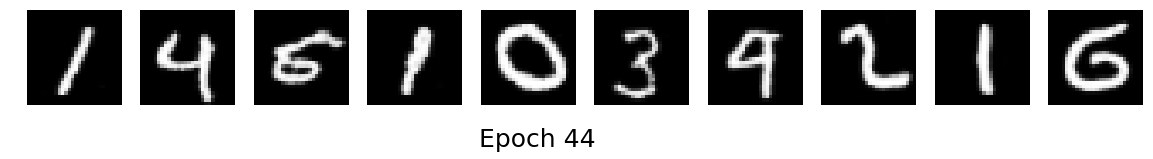

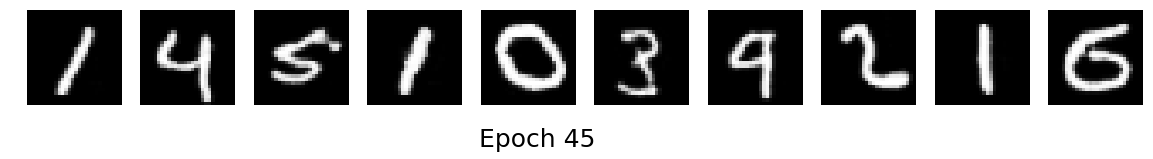

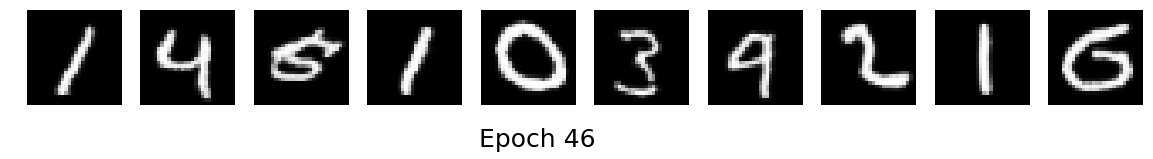

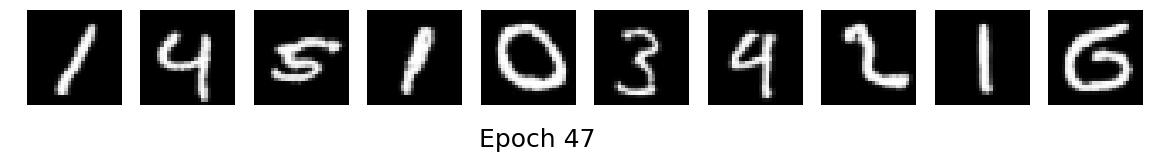

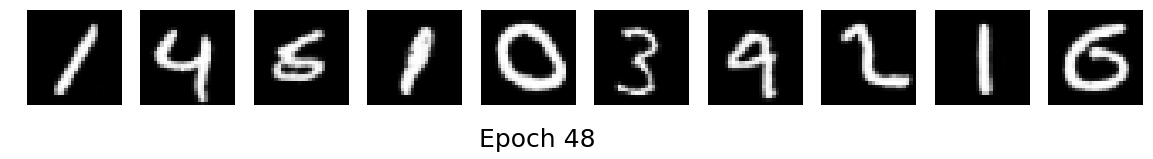

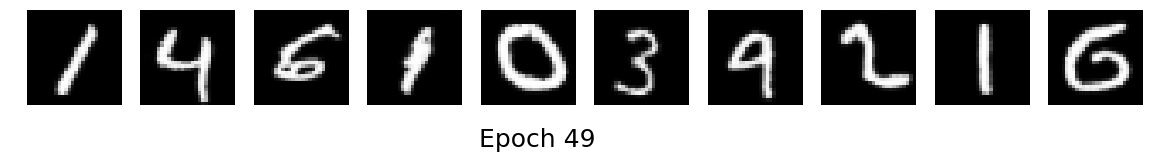

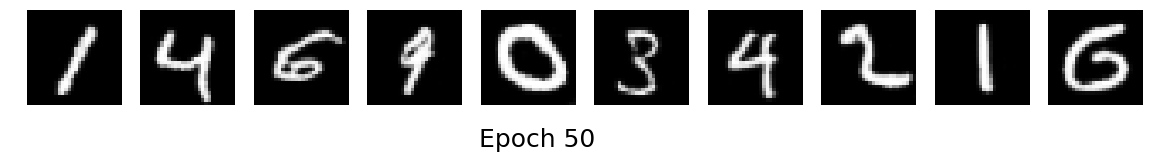

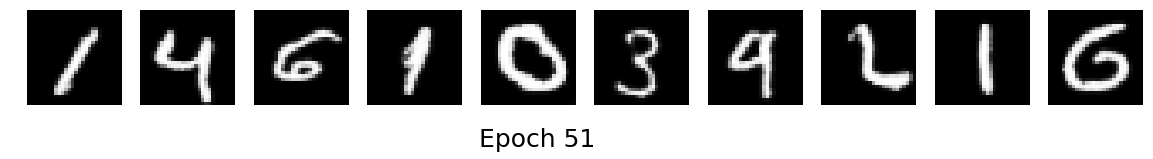

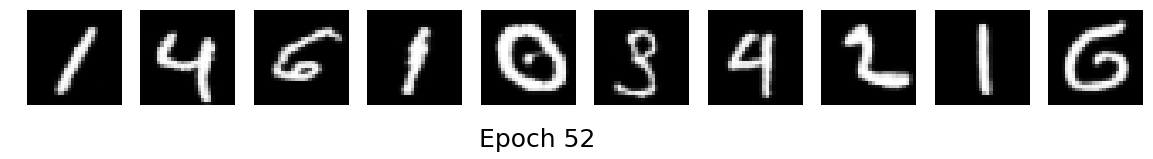

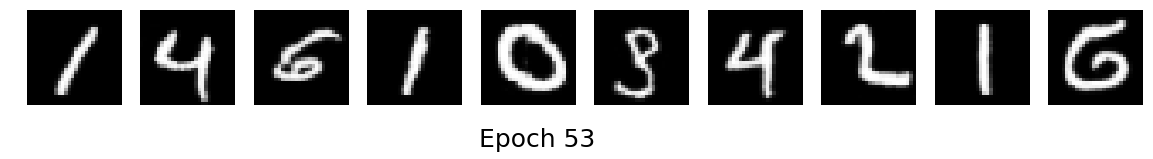

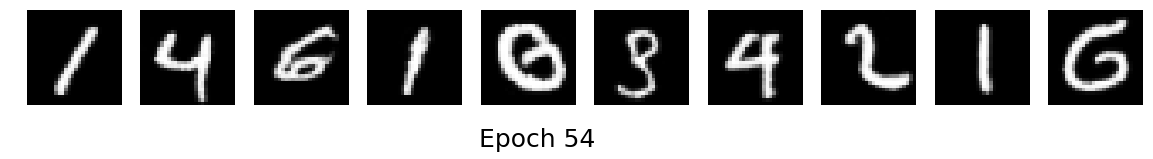

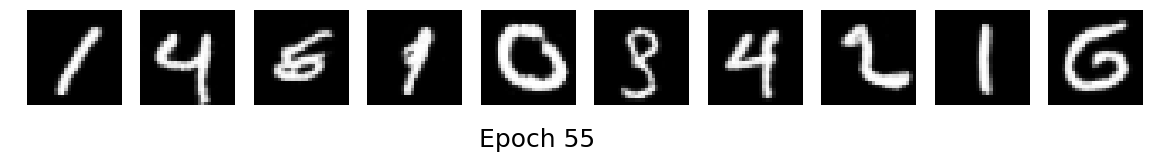

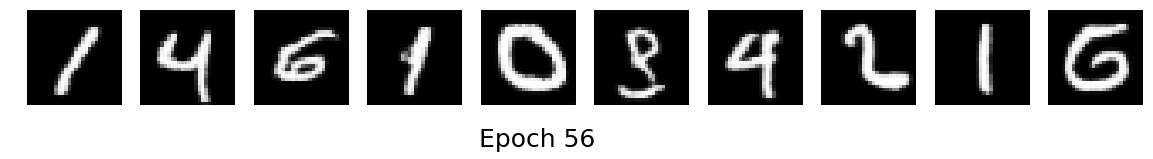

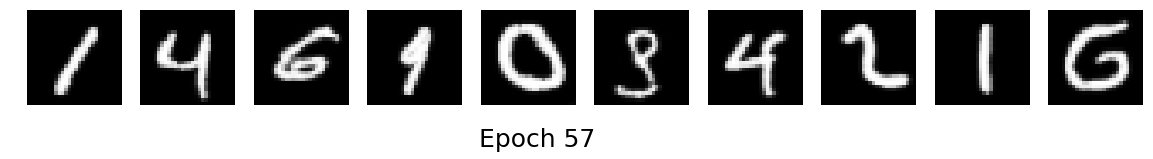

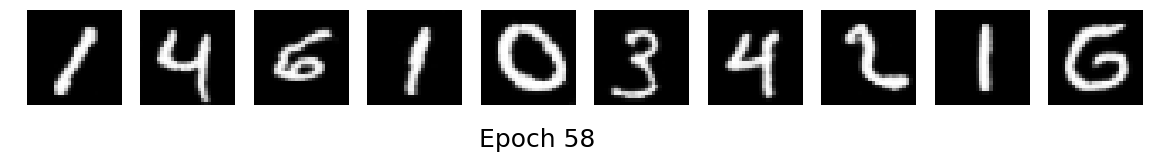

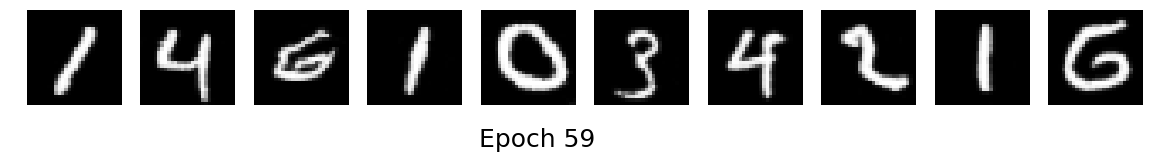

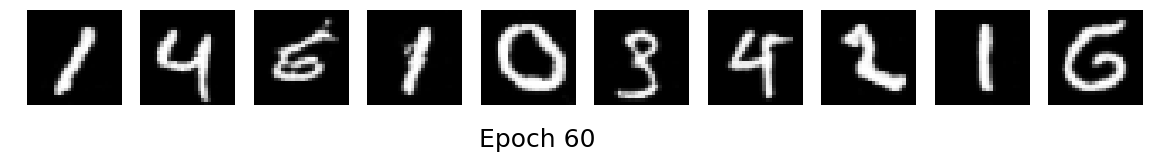

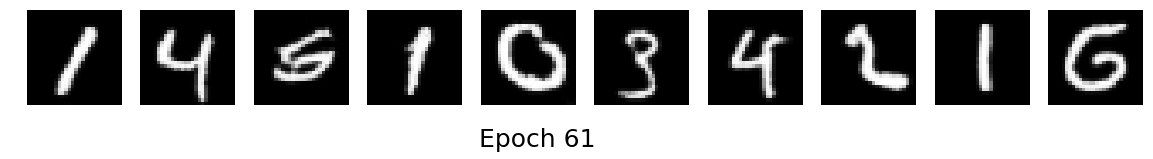

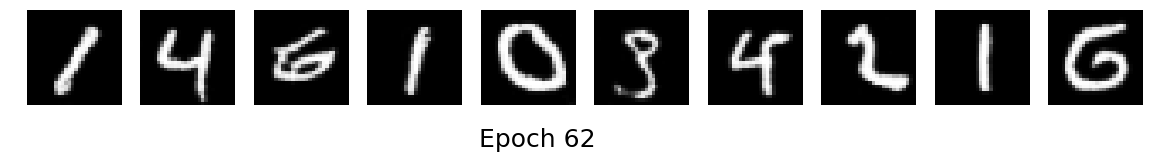

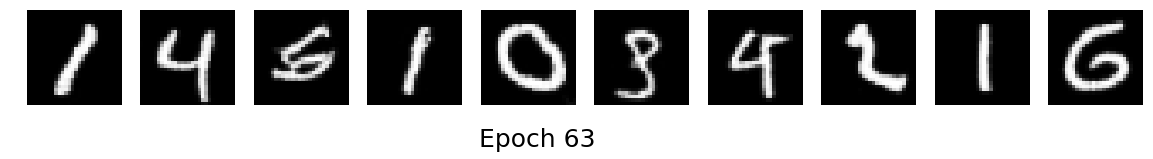

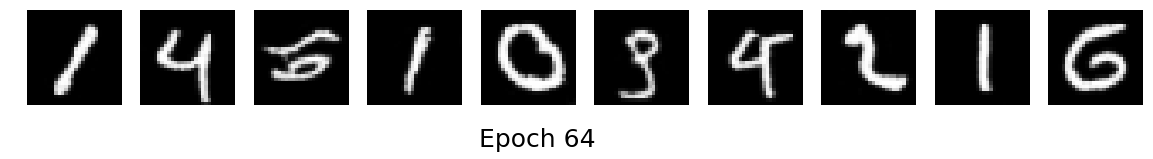

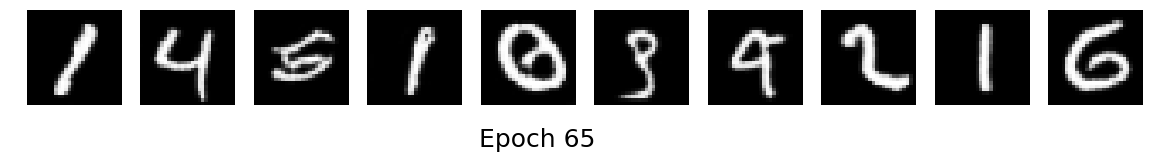

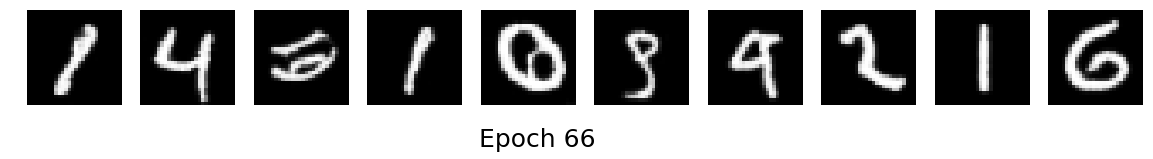

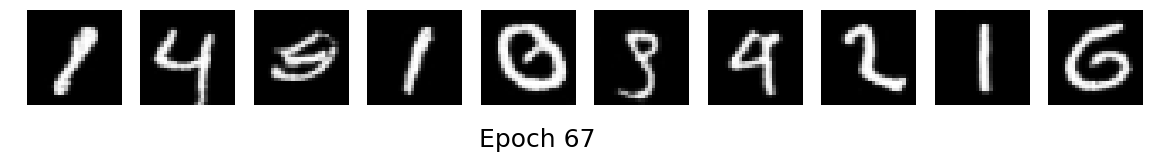

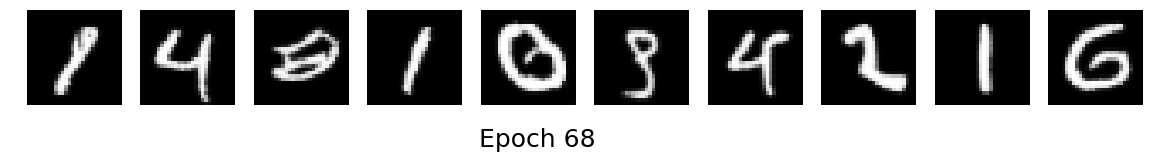

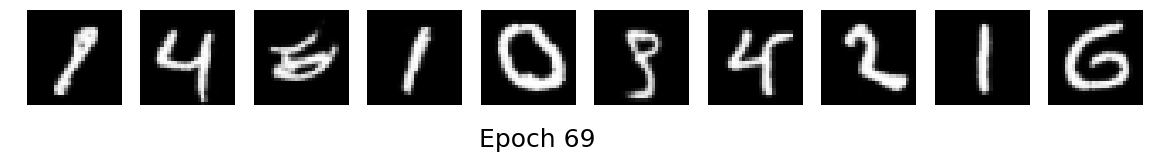

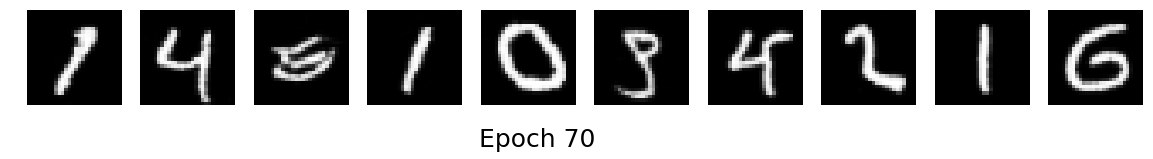

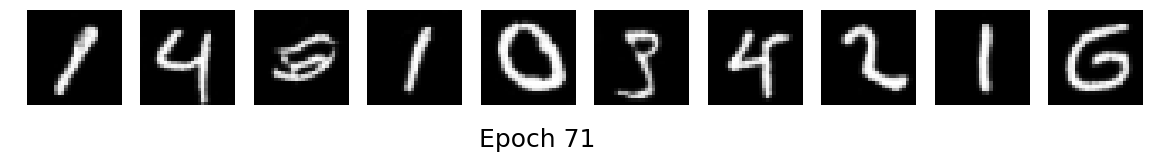

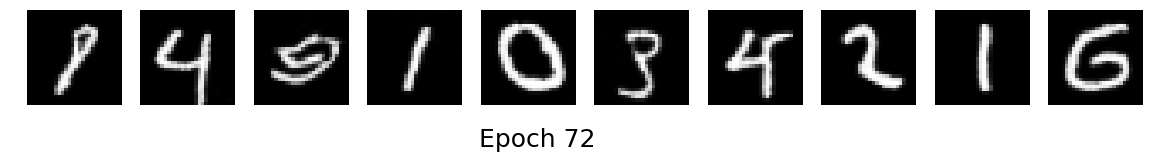

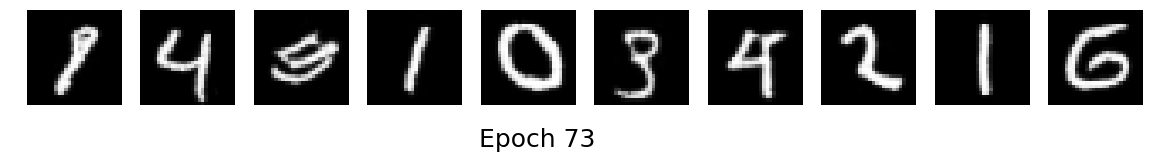

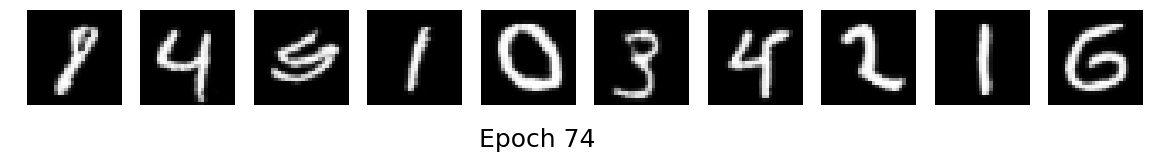

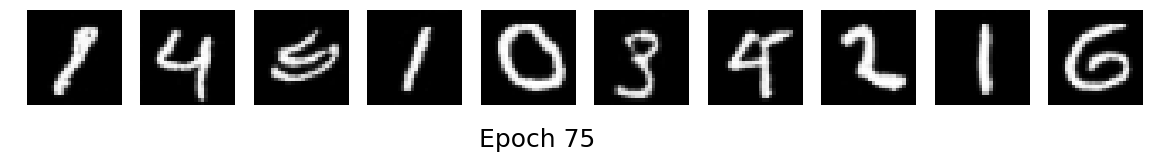

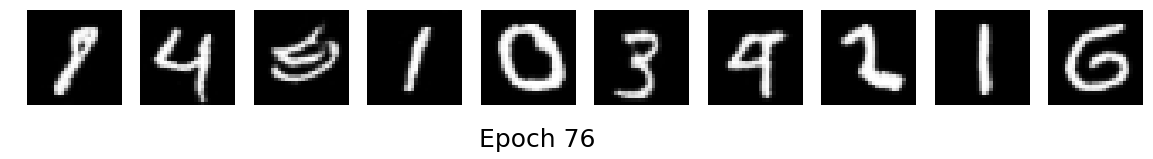

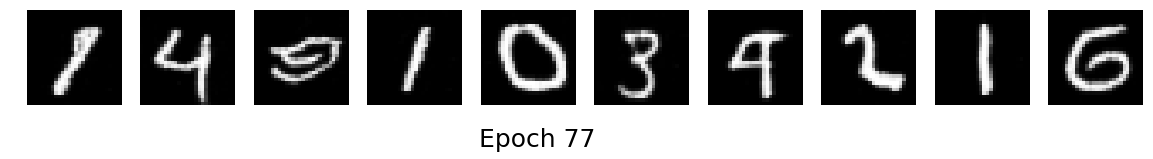

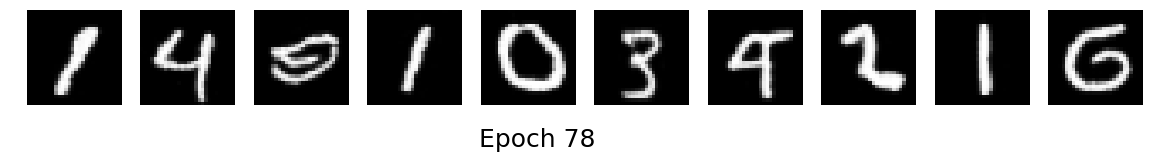

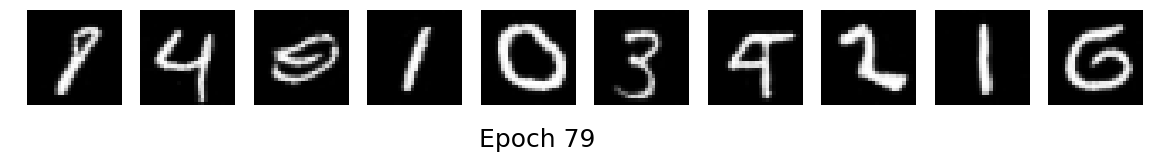

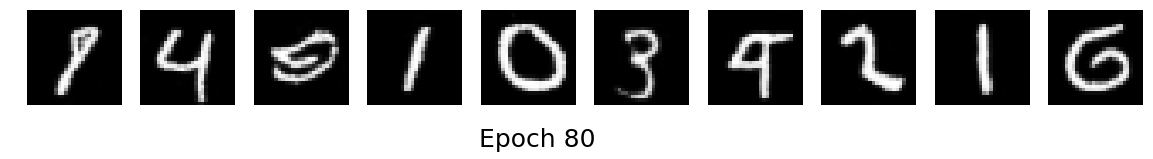

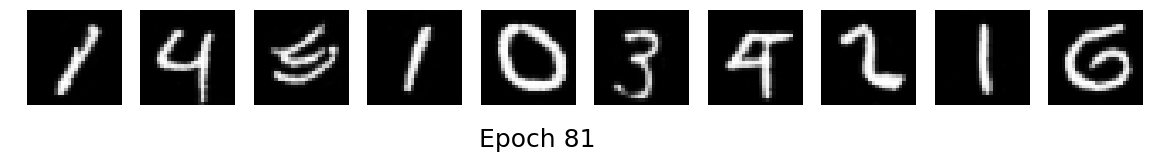

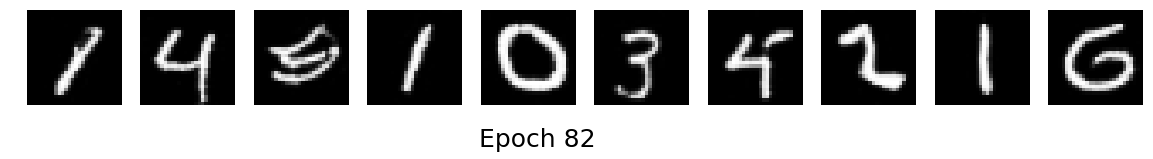

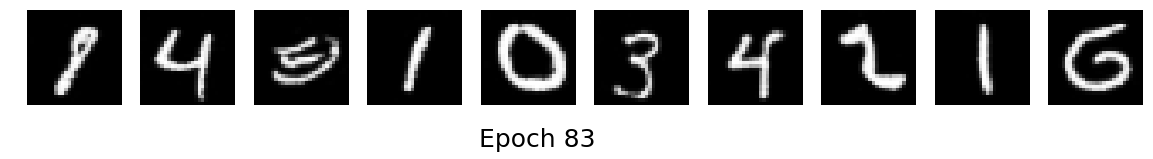

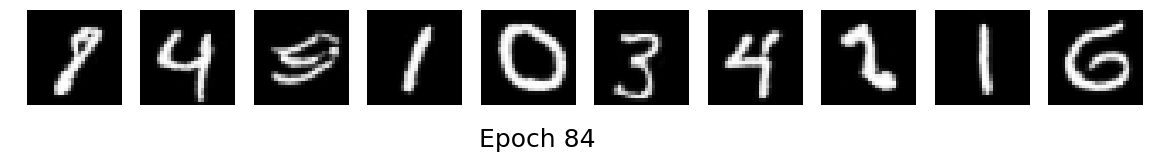

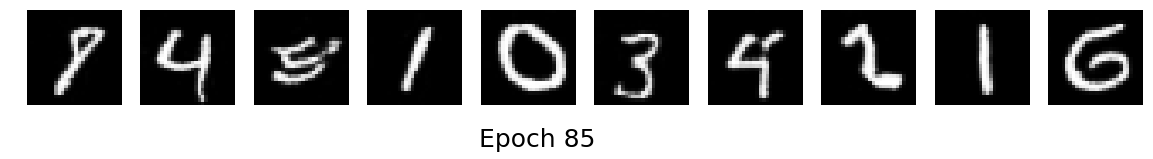

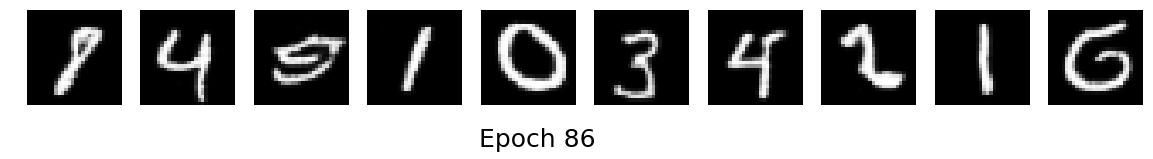

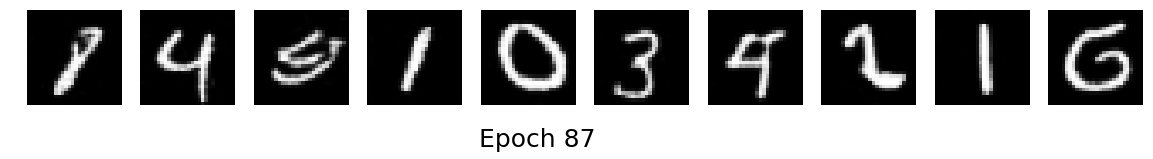

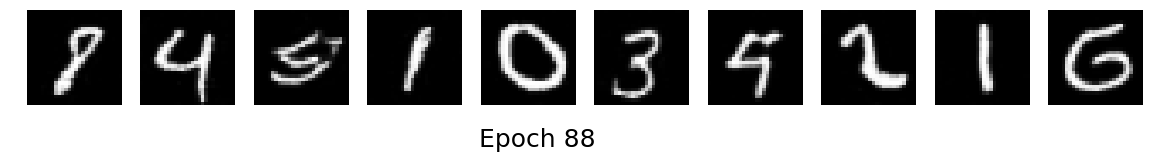

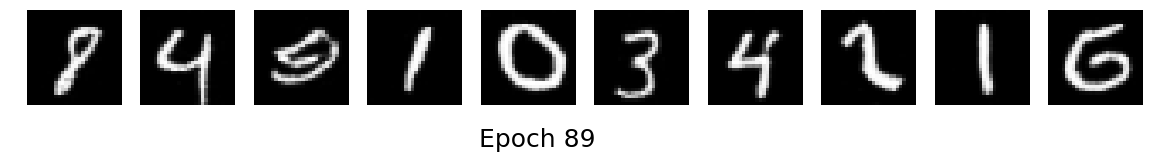

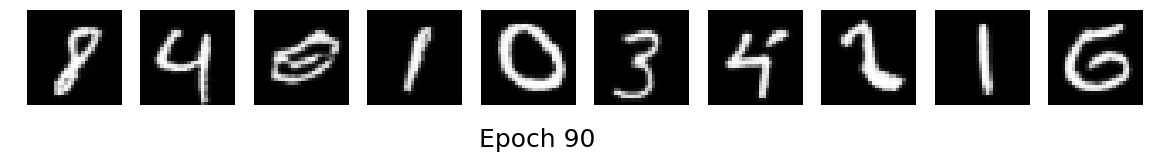

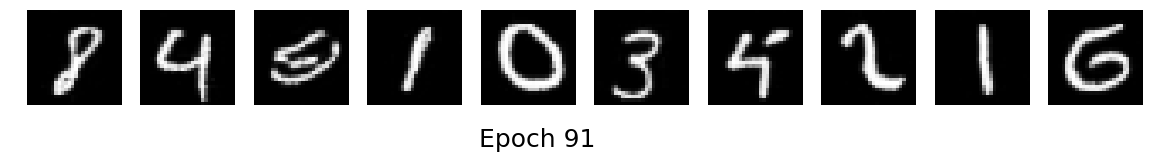

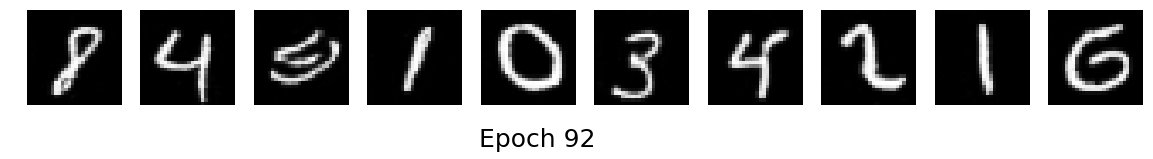

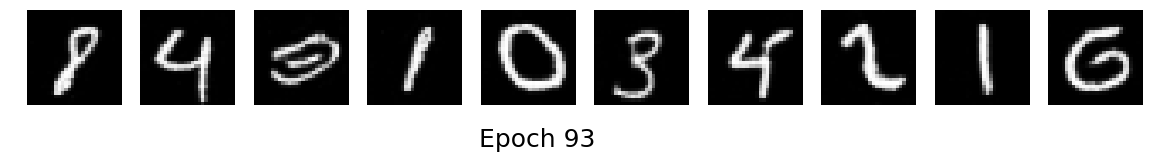

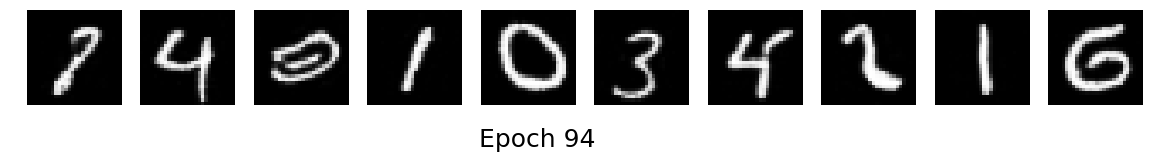

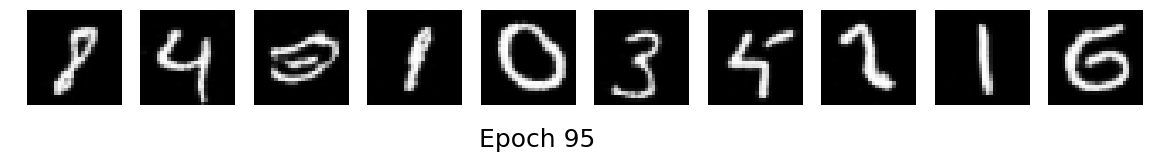

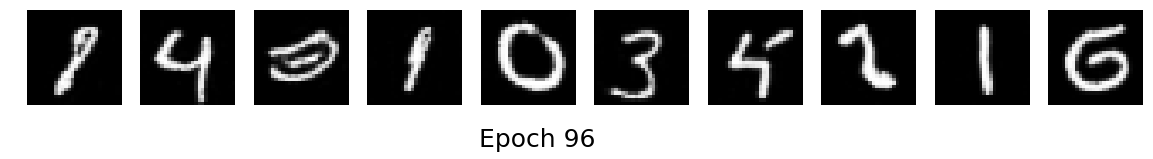

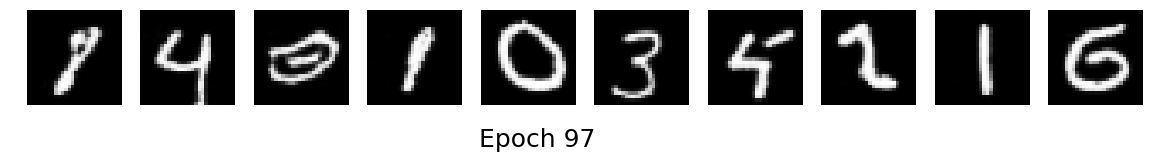

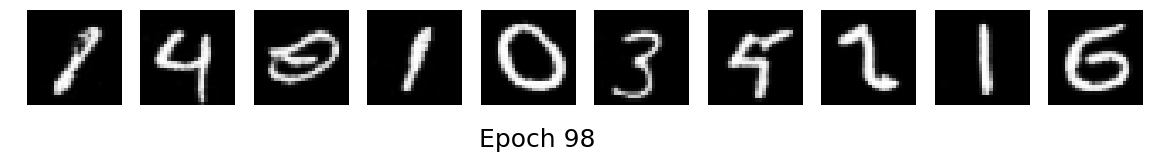

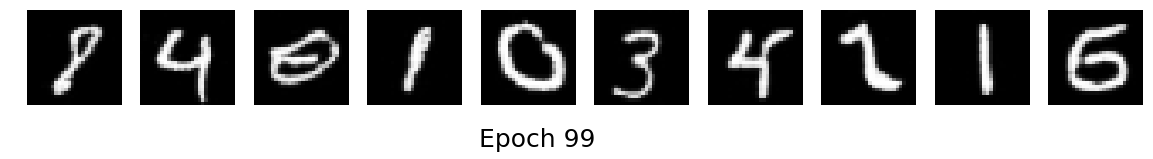

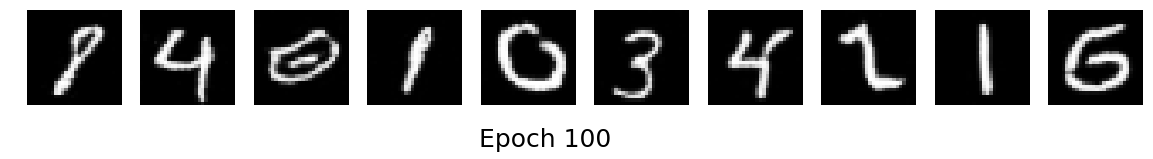

In [11]:
show_save_samples(sample_images_generated, save=True, gif_frame_duration=0.3)